**<center style="font-size:300%">미니프로젝트2 - 드라마 데이터분석</center>**
<div style="text-align: right"> 프로젝트2 기간: 2022.04.01 ~ 2022.04.07 </div> 
<br> 
<br> 
<br>
<div style="text-align: right; font-size:180%"> 그날의 온도 </div>
<div style="text-align: right; font-size:120%"> 김태완, 백인엽, 유지현, 정시언, 정인모 </div>
<br>

##### **배경**
##### 콘텐츠는 끊임없이 최신 기술과 환경변화에 적응하면서 생태계를 확장해왔고, 최근 OTT, 신기술 등은 방송영상콘텐츠의 새로운 확장의 기회를 주고 있다. 2020년 JTBC에서 방영돼 최고시청률 18.3% (닐슨코리아, 수도권 유료가구)를 기록한 '이태원 클라스'는 일본에서 리메이크가 확정됐다. 또한 최근 ‘밥 잘 사주는 예쁜 누나’ 또한 인도에서 리메이크를 확정지었다. 방송가와 시청자들의 호평을 이끈 드라마들을 분석 및 예측하여 K-콘텐츠 성장에 기여하고자 한다.

##### **주제**
##### K-드라마 프로그램, 작가, 채널, 방영시간대, 시청률 등의 TV 콘텐츠 DB(출처: TNMS TV 컨텐츠 모니터링 데이터) 로 드라마 프로그램의 성연령별 선호도를 분석 및 예측

##### **결과** 
##### 학습결과 87.6%
-----------------------------------------------

## **모듈 import**

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost

## **데이터 준비**

#### 방송사, 시청률 데이터

In [2]:
df = pd.read_csv('TN_K_DRAMA_CST_AUDERT_INFO.csv', encoding='cp949')

#### 장르, 작가 데이터

In [3]:
df_gen = pd.read_csv('drama_genre_200.csv', encoding='cp949')

## **데이터 전처리**

#### 장르와 작가 데이터를 기존 데이터 프레임에 추가

In [4]:
genre = []
writer = []
for i in df.PROGRM_NM:
    genre.append(df_gen.loc[df_gen.제목 == i].iloc[:,2].values[0])
    writer.append(df_gen.loc[df_gen.제목 == i].iloc[:,1].values[0])

df["GENRE"] = genre
df["WRITER"] = writer

#### 기존 방송날짜 컬럼을 제거하고 년도, 월, 요일 데이터를 잘라 각 컬럼으로 추가

In [5]:
year = []
month = []
day = []

for i in df['BRDCST_DE'].values:
    year.append(int(str(i)[0:4]))
    month.append(int(str(i)[4:6]))
    day.append(int(str(i)[6:8]))

week = []
for i in range(len(year)):
    date = f"{year[i]}-{month[i]}-{day[i]}"
    if(datetime.strptime(date, "%Y-%m-%d").weekday() == 0):
        week.append("월")
    elif(datetime.strptime(date, "%Y-%m-%d").weekday() == 1):
        week.append("화")
    elif(datetime.strptime(date, "%Y-%m-%d").weekday() == 2):
        week.append("수")
    elif(datetime.strptime(date, "%Y-%m-%d").weekday() == 3):
        week.append("목")
    elif(datetime.strptime(date, "%Y-%m-%d").weekday() == 4):
        week.append("금")
    elif(datetime.strptime(date, "%Y-%m-%d").weekday() == 5):
        week.append("토")
    else:
        week.append("일")

df.drop("BRDCST_DE", axis=1, inplace=True)

df["BRDCST_DE_YEAR"] = year
df["BRDCST_DE_MONTH"] = month
df["BRDCST_DE_DAY"] = week

#### 방송시작 시간 컬럼을 시간으로 분리

In [6]:
hr = []
li = []
for i in df.PROGRM_BEGIN_TIME:
    li.append("0"*(6-len(str(i))) + str(i))
    
for i in li:
    hr.append(int(i[0:2]))

df["PROGRM_BEGIN_TIME_HOUR"] = hr

#### 방송종료 시간 컬럼을 시간으로 분리

In [7]:
hr = []
li = []
for i in df.PROGRM_END_TIME:
    li.append("0"*(6-len(str(i))) + str(i))

for i in li:
    hr.append(int(i[0:2]))

df["PROGRM_END_TIME_HOUR"] = hr

#### 방송시간을 분단위로 계산하여 컬럼 생성

In [8]:
mit = []
li = []
for i in df.BRDCST_TIME:
    li.append("0"*(6-len(str(i))) + str(i))

for i in li:
    mit.append(int(i[0:2])*60 + int(i[2:4]))

df["BRDCST_TIME_MIN"] = mit

#### 데이터 분석에 필요없는 컬럼 삭제

In [9]:
df.drop(["PROGRM_BEGIN_TIME", "PROGRM_END_TIME", "PROGRM_DC", "BRDCST_TME_NM", "PROGRM_BRDCST_AREA_NM",
        "BRDCST_TIME", "PROGRM_GENRE_LCLAS_NM", "PROGRM_GENRE_MLSFC_NM", "PROGRM_GENRE_SCLAS_NM", "CST_CN", "PROGRM_NM"], axis=1, inplace=True)

#### 데이터 컬럼 순서 정렬

In [10]:
df = df[["CHNNEL_NM", "GENRE", "WRITER", "BRDCST_DE_YEAR", "BRDCST_DE_MONTH", "BRDCST_DE_DAY", "PROGRM_BEGIN_TIME_HOUR",
             "PROGRM_END_TIME_HOUR", "BRDCST_TIME_MIN",
             "MALE_4_9YO_WTCHNG_RT", "MALE_N10S_WTCHNG_RT", "MALE_N20S_WTCHNG_RT", "MALE_N30S_WTCHNG_RT",
             "MALE_N40S_WTCHNG_RT", "MALE_N50S_WTCHNG_RT", "MALE_N60S_ABOVE_WTCHNG_RT",
             "FEMALE_4_9YO_WTCHNG_RT", "FEMALE_N10S_WTCHNG_RT", "FEMALE_N20S_WTCHNG_RT", "FEMALE_N30S_WTCHNG_RT",
             "FEMALE_N40S_WTCHNG_RT", "FEMALE_N50S_WTCHNG_RT", "FEMALE_N60S_ABOVE_WTCHNG_RT"]]

##  **데이터 분석**

#### 데이터 시각화

##### 시간대, 성별나이의 시청률 그래프

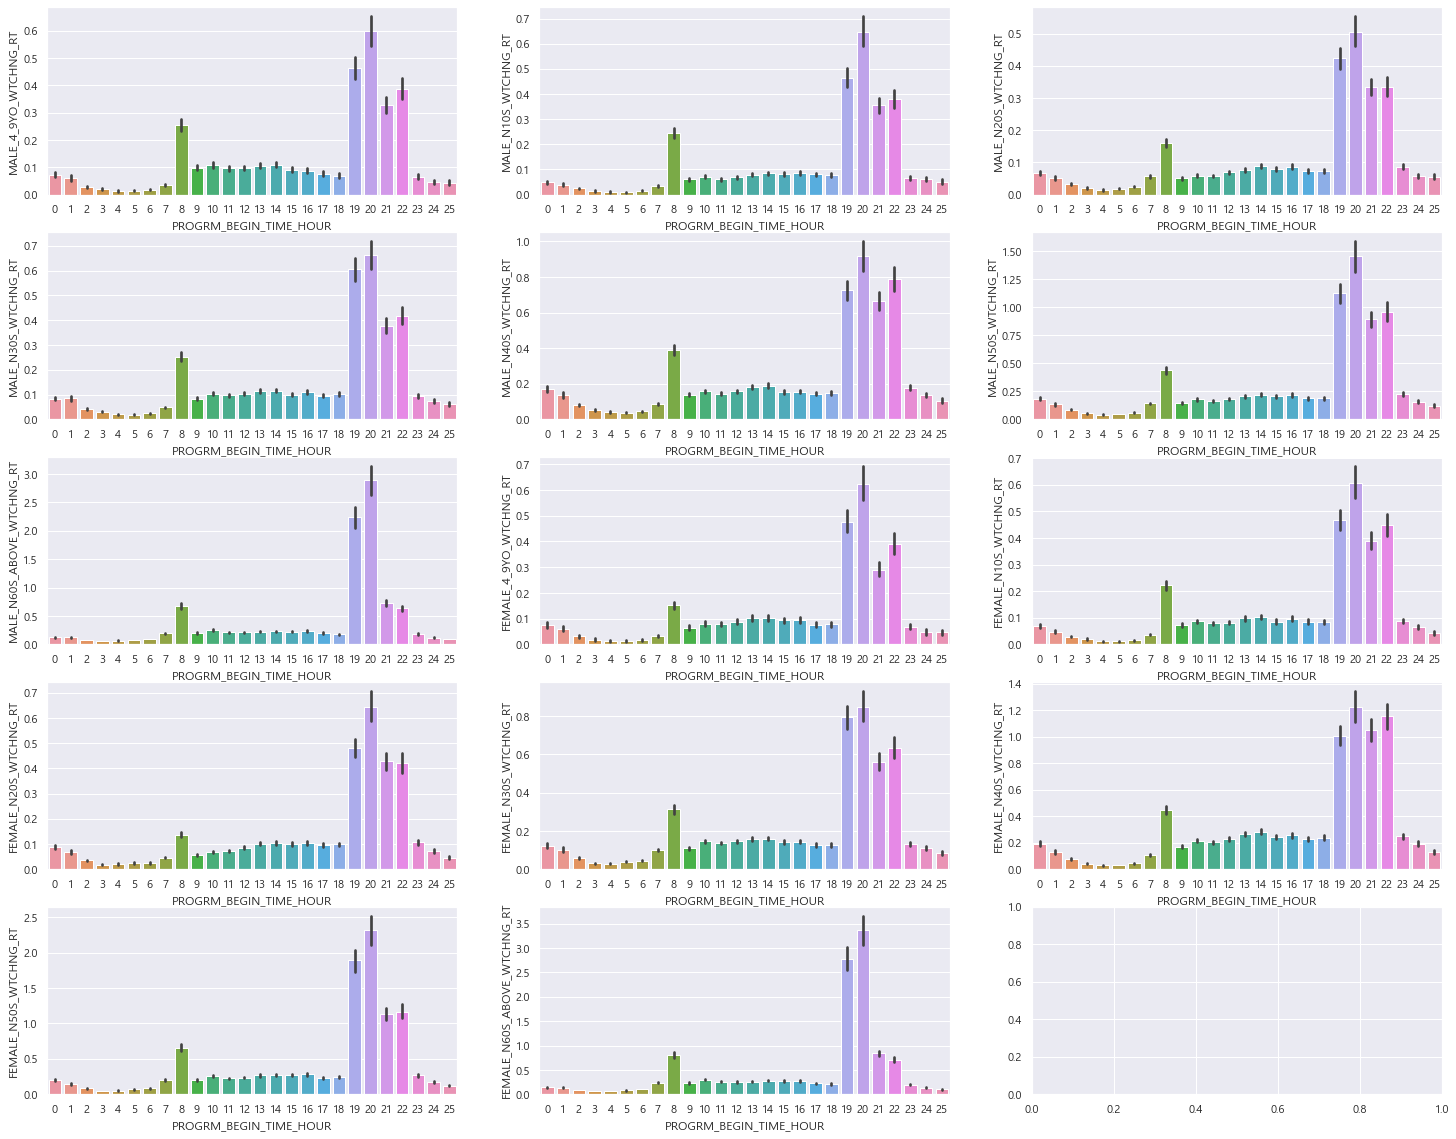

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='darkgrid')

fig, ax = plt.subplots(nrows =5, ncols = 3, figsize = (25,20))

num = 0
ax = ax.flatten()

for col in list(df.columns[9:25]):
    sns.barplot(x=df['PROGRM_BEGIN_TIME_HOUR'],y=df[col],ax=ax[num])
    num += 1
    
plt.show()

##### 요일별 시청률 그래프

<AxesSubplot:xlabel='FEMALE_N10S_WTCHNG_RT', ylabel='BRDCST_DE_DAY'>

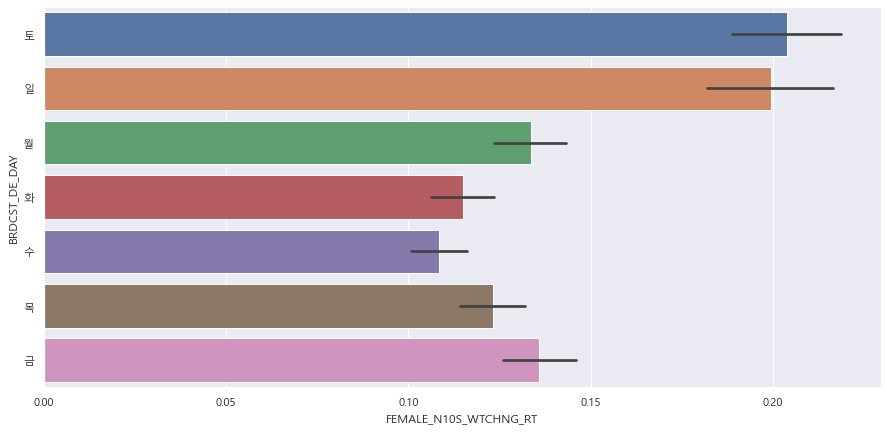

In [12]:
plt.figure(figsize=(15,7))
sns.barplot(x=df['FEMALE_N10S_WTCHNG_RT'],y=df['BRDCST_DE_DAY'],data=df)

##### 10대 여성 채널별 시청률 그래프

<AxesSubplot:xlabel='FEMALE_N10S_WTCHNG_RT', ylabel='CHNNEL_NM'>

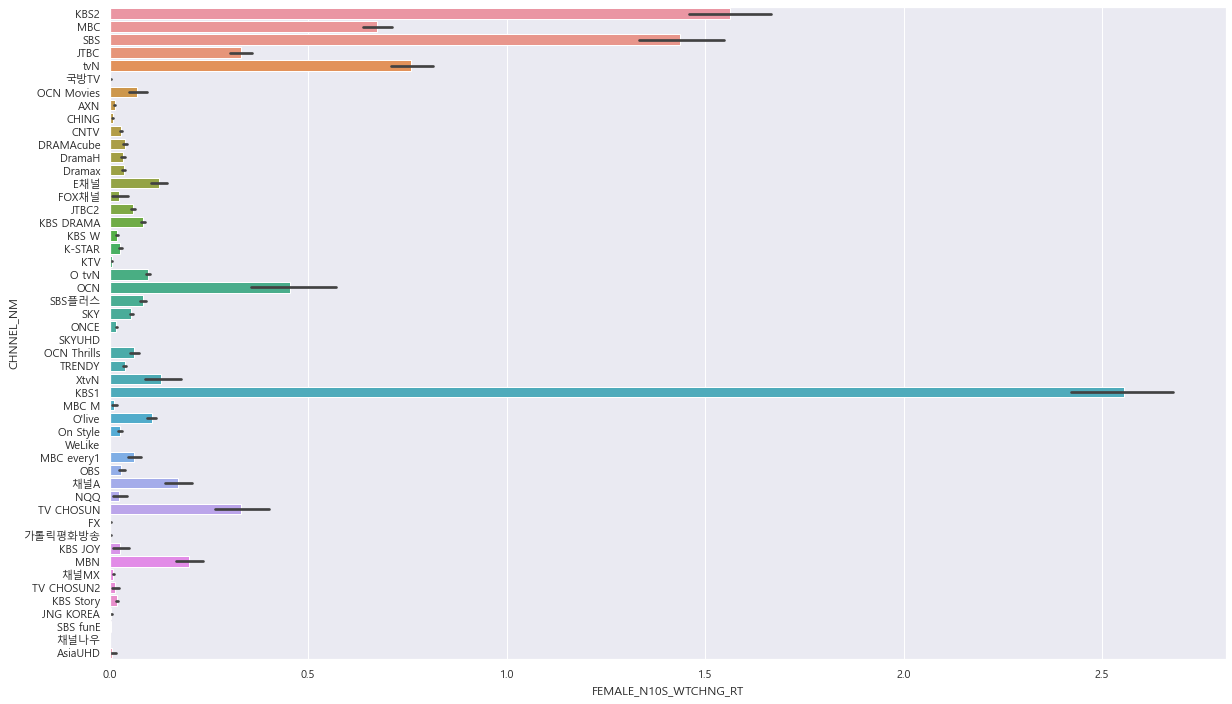

In [13]:
plt.figure(figsize=(20,12))
sns.barplot(x=df['FEMALE_N10S_WTCHNG_RT'],y=df['CHNNEL_NM'],data=df)

##### 30대 여성 장르별 시청률 그래프

<AxesSubplot:xlabel='FEMALE_N30S_WTCHNG_RT', ylabel='GENRE'>

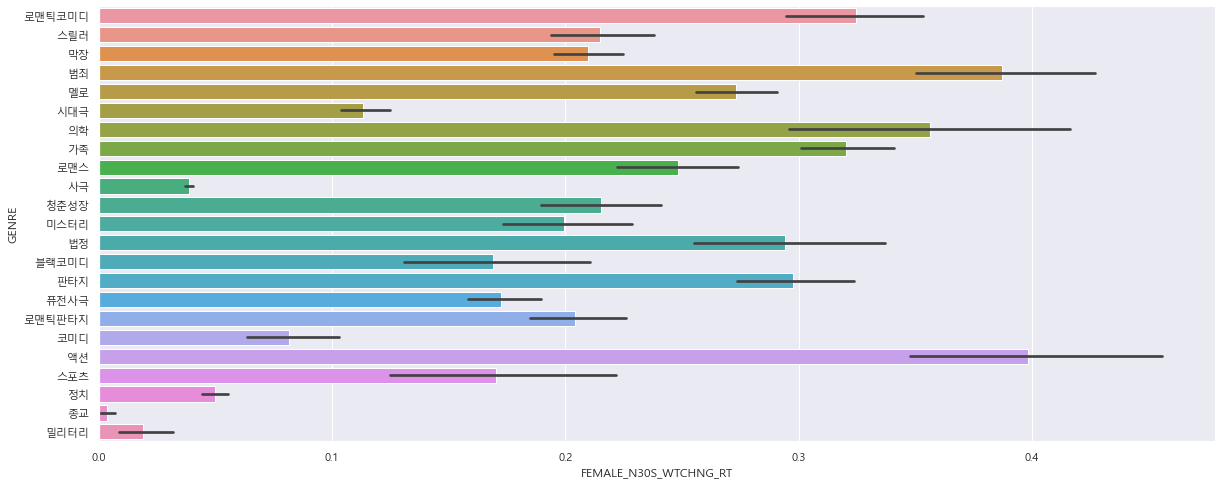

In [14]:
plt.figure(figsize=(20,8))
sns.barplot(x=df['FEMALE_N30S_WTCHNG_RT'],y=df['GENRE'],data=df)

# **데이터 분석(sklearn 사용)**

#### 범주형 데이터에 한해 원핫인코더 적용

In [18]:
ct = make_column_transformer(
    (OneHotEncoder(), ["CHNNEL_NM", "GENRE", "WRITER", "BRDCST_DE_DAY"])
)

newCols = ct.fit_transform(df).toarray()
df.drop(["CHNNEL_NM", "GENRE", "WRITER", "BRDCST_DE_DAY"], axis = 1, inplace = True)
df = pd.concat([pd.DataFrame(newCols),df], axis = 1)

#### 시청률 데이터를 간소화, 범주화
##### 5%이상 = 5
##### 1% 이상 = 4
##### 0.5% 이상 = 3
##### 0.1% 이상 = 2
##### 0.01% 이상 = 1
##### 0.01% 이하 = 0

In [19]:
dic = {}
dic2 = {}
for s in ["MALE", "FEMALE"]:
    for age in ["4_9YO", "N10S", "N20S", "N30S", "N40S", "N50S", "N60S_ABOVE"]:
        li = []
        for i in df[f"{s}_{age}_WTCHNG_RT"]:
            if(i >= 50):
                li.append(5)
            elif(i >= 10):
                li.append(4)
            elif(i >= 5):
                li.append(3)
            elif(i >= 1):
                li.append(2)
            elif(i >= 0.1):
                li.append(1)
            else:
                li.append(0)
        dic2[age] = li
    dic[s] = dic2
    
for s in ["MALE", "FEMALE"]:
    for age in ["4_9YO", "N10S", "N20S", "N30S", "N40S", "N50S", "N60S_ABOVE"]:
        df.drop(f"{s}_{age}_WTCHNG_RT", axis = 1)
for s in ["MALE", "FEMALE"]:
    for age in ["4_9YO", "N10S", "N20S", "N30S", "N40S", "N50S", "N60S_ABOVE"]:        
        df[f"{s}_{age}_WTCHNG_RT"] = dic[s][age]

#### 최종 데이터프레임

In [28]:
df = df[["BRDCST_DE_YEAR","BRDCST_DE_MONTH","PROGRM_BEGIN_TIME_HOUR",
             "PROGRM_END_TIME_HOUR", "BRDCST_TIME_MIN",
             "MALE_4_9YO_WTCHNG_RT", "MALE_N10S_WTCHNG_RT", "MALE_N20S_WTCHNG_RT", "MALE_N30S_WTCHNG_RT",
             "MALE_N40S_WTCHNG_RT", "MALE_N50S_WTCHNG_RT", "MALE_N60S_ABOVE_WTCHNG_RT",
             "FEMALE_4_9YO_WTCHNG_RT", "FEMALE_N10S_WTCHNG_RT", "FEMALE_N20S_WTCHNG_RT", "FEMALE_N30S_WTCHNG_RT",
             "FEMALE_N40S_WTCHNG_RT", "FEMALE_N50S_WTCHNG_RT", "FEMALE_N60S_ABOVE_WTCHNG_RT"]]

AttributeError: 'list' object has no attribute 'values'

In [23]:
df

,0,1,2,3,4,5,6,7,8,9,...,MALE_N40S_WTCHNG_RT,MALE_N50S_WTCHNG_RT,MALE_N60S_ABOVE_WTCHNG_RT,FEMALE_4_9YO_WTCHNG_RT,FEMALE_N10S_WTCHNG_RT,FEMALE_N20S_WTCHNG_RT,FEMALE_N30S_WTCHNG_RT,FEMALE_N40S_WTCHNG_RT,FEMALE_N50S_WTCHNG_RT,FEMALE_N60S_ABOVE_WTCHNG_RT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,2,2,1,1,1,1,1,2,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2,2,2,1,1,1,2,2,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2,2,2,1,1,1,2,2,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,2,2,2,1,2,1,2,2,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,4,4,3,2,3,3,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
75928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
75929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
75930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,1,1,1


## **모델학습**

In [18]:
X = df.iloc[:, :-14]
y = df.iloc[:,-14:]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

rf_model = RandomForestClassifier() 
rf_model.fit(X_train,y_train)
rf_result = rf_model.predict_proba(X_test)
rf_pred = rf_model.predict(X_test)

In [19]:
pd.DataFrame(rf_pred)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,1,0,0,0,1,1,0,1
2,0,0,0,0,1,1,1,0,0,0,0,1,1,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0,0,1,0,1,1,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15182,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15183,0,0,0,0,0,0,1,0,0,0,0,0,0,1
15184,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15185,0,0,0,1,1,1,1,0,0,0,1,1,1,1


In [20]:
y_test

,MALE_4_9YO_WTCHNG_RT,MALE_N10S_WTCHNG_RT,MALE_N20S_WTCHNG_RT,MALE_N30S_WTCHNG_RT,MALE_N40S_WTCHNG_RT,MALE_N50S_WTCHNG_RT,MALE_N60S_ABOVE_WTCHNG_RT,FEMALE_4_9YO_WTCHNG_RT,FEMALE_N10S_WTCHNG_RT,FEMALE_N20S_WTCHNG_RT,FEMALE_N30S_WTCHNG_RT,FEMALE_N40S_WTCHNG_RT,FEMALE_N50S_WTCHNG_RT,FEMALE_N60S_ABOVE_WTCHNG_RT
49118,0,1,0,0,0,0,0,0,1,0,0,0,0,0
48280,0,0,0,1,0,0,1,0,0,0,1,0,0,1
1551,0,0,0,1,1,1,1,0,0,0,1,1,1,1
58418,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36618,0,0,1,1,0,1,1,0,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51090,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9839,0,0,0,0,0,0,0,0,0,0,0,0,0,0
74383,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8831,1,0,0,1,0,1,1,1,0,0,1,0,1,1


#### 4세 이상 9세 이하 남자아이에 한하여 예측 데이터 정확도

In [21]:
X = df.iloc[:, 0:-14]
y = df.iloc[:,-14]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

rf_model = RandomForestClassifier() 
ada_model = AdaBoostClassifier()
lr_model = LogisticRegression()
svc_model = SVC(probability=True)
meta_model = KNeighborsClassifier()
xgb_param = {
    "n_estimators":100, 
     "learning_rate":0.08, 
     "gamma":0, 
      "subsample":0.75,
      "colsample_bytree":1, 
      "max_depth":7,
    "verbosity":0
}
xgb_model = xgboost.XGBClassifier(**xgb_param)

rf_model.fit(X_train,y_train)
ada_model.fit(X_train,y_train)
lr_model.fit(X_train,y_train)
svc_model.fit(X_train,y_train)
xgb_model.fit(X_train,y_train)

rf_result = rf_model.predict_proba(X_test)
ada_result = ada_model.predict_proba(X_test)
lr_result = lr_model.predict_proba(X_test)
svc_result = svc_model.predict_proba(X_test)
xgb_result = xgb_model.predict_proba(X_test)

print("rf_model :",rf_model.score(X_test,y_test))
print("ada_model :",ada_model.score(X_test,y_test))
print("lr_model :",lr_model.score(X_test,y_test))
print("svc_model :",svc_model.score(X_test,y_test))
print("xgb_model :",xgb_model.score(X_test,y_test))

v1 = rf_model.predict(X_train)
v2 = ada_model.predict(X_train)
v3 = lr_model.predict(X_train)
v4 = svc_model.predict(X_train)
v5 = xgb_model.predict(X_train)
X_train_meta = np.c_[v1,v2,v3,v4,v5]

meta_model.fit(X_train_meta,y_train)

v1 = rf_model.predict(X_test)
v2 = ada_model.predict(X_test)
v3 = lr_model.predict(X_test)
v4 = svc_model.predict(X_test)
v5 = xgb_model.predict(X_test)
X_test_meta = np.c_[v1,v2,v3,v4,v5]
meta_model.score(X_test_meta,y_test)

rf_model : 0.8529663528017384
ada_model : 0.8493448343978403
lr_model : 0.8548100348982682
svc_model : 0.8548100348982682
xgb_model : 0.8754856126950682


0.8534931191150326

#### 예측값에 가장 많은 영향을 미친 컬럼 시각화

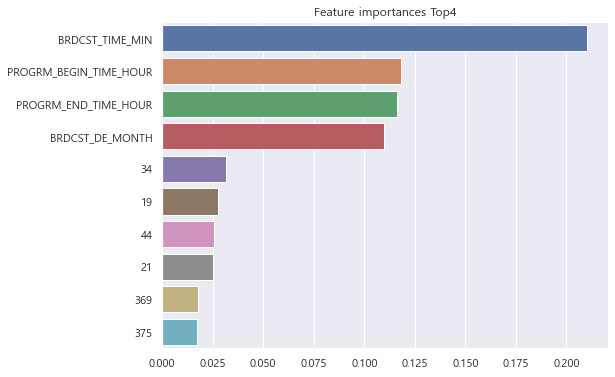

In [22]:
ftr_importances_values = rf_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top4')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

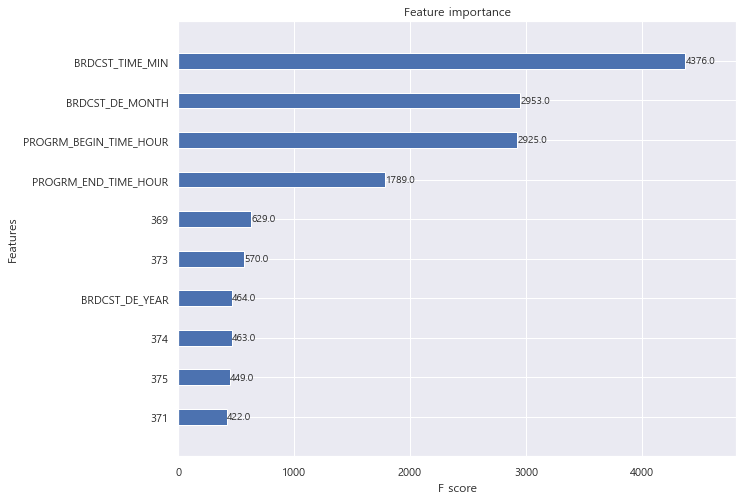

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=10, height=0.4)